# Test model on reader-specific questions
We have previously determined that the reader-aware model does (slightly) better on divisive posts.

How well does the model do on questions that are highly associated with a specific reader group? E.g. if P(reader == EXPERT) is high (based on classification model or reader traits), does the generation model catch those questions better?

In [12]:
## load data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
print(test_data.shape)

(53080, 17)


In [5]:
## load data cleaning PCA models
import pickle
PCA_post_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=post_encoded.pkl', 'rb'))
PCA_question_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=question_encoded.pkl', 'rb'))

In [6]:
## load classification models
import os
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
reader_group_models = {}
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
for reader_group_i in reader_groups:
    default_class_i = reader_group_default_class[reader_group_i]
    model_file_i = os.path.join(model_dir, f'MLP_prediction_group={reader_group_i}_class1={default_class_i}.pkl')
    reader_group_models[reader_group_i] = pickle.load(open(model_file_i, 'rb'))

In [18]:
## load embedding model
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

In [76]:
## use PCA to compress data
import numpy as np
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.fit_transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })

In [74]:
## assign labels
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'reader_group' : test_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
test_data = test_data.assign(**{
    'reader_group_class' : test_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})

In [77]:
## predict class for all reader groups
import pandas as pd
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
pred_test_data = []
for reader_group_i in reader_groups:
    # clean data etc.
    test_data_i = test_data[test_data.loc[:, 'reader_group']==reader_group_i]
    question_post_text_i = np.hstack([np.vstack(test_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(test_data_i.loc[:, 'PCA_post_encoded'].values)])
    # do prediction!!
    reader_group_model_i = reader_group_models[reader_group_i]
    pred_prob_i = reader_group_model_i.predict_proba(question_post_text_i)
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred' : np.argmax(pred_prob_i, axis=1)
    })
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_prob' : np.max(pred_prob_i, axis=1)
    })
    pred_test_data.append(test_data_i)
pred_test_data = pd.concat(pred_test_data, axis=0)

In [78]:
## let's check out accuracy
from sklearn.metrics import f1_score
for reader_group_i, data_i in pred_test_data.groupby('reader_group'):
    print(f'label dist =\n{data_i.loc[:, "reader_group_class"].value_counts()}')
    print(f'pred dist =\n{data_i.loc[:, "reader_group_class_pred"].value_counts()}')
    f1_i = f1_score(data_i.loc[:, 'reader_group_class'].values, data_i.loc[:, 'reader_group_class_pred'].values, average='macro')
    print(f'reader group = {reader_group_i} has F1={"{:.3f}".format(f1_i)}')

label dist =
1    10070
0     4254
Name: reader_group_class, dtype: int64
pred dist =
0    8242
1    6082
Name: reader_group_class_pred, dtype: int64
reader group = expert_pct_bin has F1=0.463
label dist =
0    1459
1    1189
Name: reader_group_class, dtype: int64
pred dist =
0    1377
1    1271
Name: reader_group_class_pred, dtype: int64
reader group = location_region has F1=0.504
label dist =
0    8245
1    6079
Name: reader_group_class, dtype: int64
pred dist =
0    13338
1      986
Name: reader_group_class_pred, dtype: int64
reader group = relative_time_bin has F1=0.412


This is bad! Maybe there's an issue with data shift?

Let's retrain and test the model on balanced data.

In [126]:
## get train data, re-clean etc, combine with test data
train_data = torch.load('../../data/reddit_data/combined_data_train_data.pt').data.to_pandas()
train_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
## assign labels
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
train_data = train_data.assign(**{
    'reader_group' : train_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
train_data = train_data.assign(**{
    'reader_group_class' : train_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})
train_test_data = pd.concat([train_data, test_data], axis=0)
## add subreddit data for later sampling
import pandas as pd
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit'])
post_data.rename(columns={'id' : 'article_id'}, inplace=True)
train_test_data = pd.merge(train_test_data, post_data, on='article_id', how='left')

In [128]:
## recompute PCA etc.
trained_PCA_models = []
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
from sklearn.decomposition import PCA
embed_vars = ['question', 'post']
PCA_dim = 100
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(train_test_data.loc[:, embed_var_i].values, batch_size=32, device=torch.cuda.current_device(), show_progress_bar=True)
    train_test_data = train_test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
    # PCA transform
    PCA_model_i = PCA(n_components=PCA_dim, random_state=123)
    PCA_embed_i = PCA_model_i.fit_transform(np.vstack(train_test_data.loc[:, encode_var_i].values))
    train_test_data = train_test_data.assign(**{
        f'PCA_{encode_var_i}' : [PCA_embed_i[j, :] for j in range(PCA_embed_i.shape[0])]
    })

Batches:   0%|          | 0/8133 [00:00<?, ?it/s]

Batches:   0%|          | 0/8133 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [121]:
# check question nearest neighbors
sample_data = train_test_data.iloc[200, :]
print(sample_data.loc['question'])
sample_question_embed = sample_data.loc['PCA_question_encoded']
from sklearn.metrics.pairwise import cosine_similarity
sample_question_embed_sim = cosine_similarity(sample_question_embed.reshape(1,-1), np.vstack(train_test_data.loc[:, 'PCA_question_encoded'].values))
top_k = 10
top_k_sim_data = train_test_data.iloc[np.argsort(sample_question_embed_sim[0])[::-1][1:(top_k+1)], :]
display(top_k_sim_data.loc[:, 'question'])

I'm just confused why she even knows what your documents are?


174807    I'm just confused why she even knows what your...
134572    Does she have *any* documents with her real ag...
164758    Is there somewhere her father kept most of his...
136346    Is there somewhere her father kept most of his...
157111                     Do you not have those documents?
191358                     Do you not have those documents?
105907    Is she just forgetful and/or lazy, or is she t...
11449     Though she isn't curious where your entire che...
44601     Though she isn't curious where your entire che...
117364                 Sp have you actually read her stuff?
Name: question, dtype: object

OK! These representations are actually meaningful.

In [135]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
k_folds = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
layer_size = PCA_dim * 2
sample_size = 10000
for reader_group_i in reader_groups:
    data_i = train_test_data[train_test_data.loc[:, 'reader_group']==reader_group_i]
    # tmp debug
#     sample_size_i = min(sample_size, data_i.shape[0])
#     data_i = data_i.sample(sample_size_i, replace=False, random_state=123)
    # sample by subreddit
    subreddit_sample_size_i = data_i.loc[:, 'subreddit'].value_counts().min()
    sample_data_i = data_i.groupby('subreddit').apply(lambda x: x.sample(subreddit_sample_size_i, replace=False, random_state=123)).reset_index(drop=True)
    X = np.hstack([np.vstack(sample_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(sample_data_i.loc[:, 'PCA_post_encoded'].values)])
    Y = sample_data_i.loc[:, 'reader_group_class'].values
    acc_scores_i = []
    for j, (train_idx, test_idx) in tqdm(enumerate(k_folds.split(X, Y))):
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        model = MLPClassifier(hidden_layer_sizes=[layer_size,], activation='relu', solver='lbfgs', max_iter=1000, random_state=123)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        acc_score_j = (Y_pred==Y_test).sum() / len(Y_test)
        f1_score_j = f1_score(Y_test, Y_pred)
        print(f'iter {j} has acc={"{:.3f}".format(acc_score_j)} F1={"{:.3f}".format(f1_score_j)}')
        acc_scores_i.append([acc_score_j, f1_score_j])
    acc_scores_i = pd.DataFrame(acc_scores_i, columns=['acc', 'f1'])
    print(f'reader group {reader_group_i} has mean acc = {acc_scores_i.loc[:, "acc"].mean()}; F1={acc_scores_i.loc[:, "f1"].mean()}')

1it [02:03, 123.01s/it]

iter 0 has acc=0.523 F1=0.447


2it [03:50, 114.13s/it]

iter 1 has acc=0.540 F1=0.464


3it [05:39, 111.68s/it]

iter 2 has acc=0.512 F1=0.438


4it [07:21, 107.94s/it]

iter 3 has acc=0.528 F1=0.444


4it [07:48, 117.17s/it]


KeyboardInterrupt: 

This "train-from-scratch" approach isn't working out.

Why don't we just use the data that we used in the group classification model results? We balanced the data to have at least one question from each reader group per post.

In [1]:
# load sample data
import pandas as pd
import re
import numpy as np
arr_matcher = re.compile('[\[\]\n]')
embed_vars = ['question', 'post']
embed_var_converters = {
    f'PCA_{embed_var}_encoded': lambda x: np.fromstring(arr_matcher.sub('', x).strip(), sep=' ', dtype=float)
    for embed_var in embed_vars
}
post_question_data_file = '../../data/reddit_data/group_classification_model/sample_type=paired_post_question_data.gz'
post_question_data = pd.read_csv(post_question_data_file, sep='\t', compression='gzip', index_col=False,
                                 converters=embed_var_converters)
# fix author group
post_question_data = post_question_data.assign(**{
    'author_group' : post_question_data.loc[:, 'author_group'].apply(lambda x: str(x) if type(x) is not str else x)
})
# limit to test data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'article_id' : 'parent_id'}, inplace=True)
test_post_question_data = post_question_data[post_question_data.loc[:, 'parent_id'].isin(test_data.loc[:, 'parent_id'].unique())]
print(f'{test_post_question_data.shape[0]}/{post_question_data.shape[0]}')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


41132/209884


In [47]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
def resample_by_class(data, class_var='author_group', class_count='min'):
    data_class_counts = data.loc[:, class_var].value_counts()
#     print(f'data class counts = {data_class_counts}')
    if(class_count == 'min'):
        data_class_count_base = data_class_counts.min()
        data_class = data_class_counts.sort_values(ascending=True).index[0]
    elif(class_count == 'max'):
        data_class_count_base = data_class_counts.max()
        data_class = data_class_counts.sort_values(ascending=False).index[0]
#     print(f'min class = {data_min_class}')
    data = pd.concat(
        [data[data.loc[:, class_var]==data_class], 
         data[data.loc[:, class_var]!=data_class].sample(data_class_count_base, replace=(class_count=='max'), random_state=123)],
    axis=0)
#     print(f'post-stratify data class counts = {data.loc[:, class_var].value_counts()}')
    return data
np.random.seed(123)
text_var = 'PCA_question_encoded'
post_var = 'PCA_post_encoded'
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
n_folds = 5
reader_group_model_scores = []
train_pct = 0.8
for group_category_i, data_i in test_post_question_data.groupby('group_category'):
    X = np.hstack([np.vstack(data_i.loc[:, text_var].values), np.vstack(data_i.loc[:, post_var].values)])
#     X = np.vstack(data_i.loc[:, text_var].values)
    layer_size = X.shape[1]
    Y = data_i.loc[:, 'author_group'].values
    # convert to binary
    default_class_i = reader_group_default_class[group_category_i]
    non_default_class_i = list(set(Y) - {default_class_i})[0]
    Y = (Y==default_class_i).astype(int)
    # fit models across all folds
    model_scores = []
    k_folds = StratifiedKFold(n_splits=n_folds, random_state=123, shuffle=True)
    subreddits = data_i.loc[:, 'subreddit'].unique()
    data_i = data_i.assign(**{'idx' : list(range(data_i.shape[0]))})
    parent_id_i = data_i.loc[:, 'parent_id'].unique()
    train_N_i = int(len(parent_id_i) * train_pct)
    # split by parent ID
    for j in tqdm(range(n_folds)):
        train_id_j = set(np.random.choice(parent_id_i, train_N_i, replace=False))
        test_id_j = list(set(parent_id_i) - train_id_j)
        train_idx = np.where(data_i.loc[:, 'parent_id'].isin(train_id_j))[0]
        test_idx = np.where(data_i.loc[:, 'parent_id'].isin(test_id_j))[0]
    # k-fold splitting => need to prevent shared info from shared posts
#     for j, (train_idx, test_idx) in tqdm(enumerate(k_folds.split(X, Y))):
        # remove shared posts from test data
#         train_id_j = set(data_i.iloc[train_idx, :].loc[:, 'parent_id'].unique())
#         test_idx = list(set(test_idx) - set(np.where(data_i.loc[:, 'parent_id'].isin(train_id_j))[0]))
#         print(len(test_idx))
        # resample data to avoid class distribution imbalance
        train_data_i = data_i.iloc[train_idx, :]
        train_data_i = resample_by_class(train_data_i, class_var='author_group', class_count='max')
        train_idx = train_data_i.loc[:, 'idx'].values
        test_data_i = data_i.iloc[test_idx, :]
        test_data_i = resample_by_class(test_data_i, class_var='author_group', class_count='max')
        test_idx = test_data_i.loc[:, 'idx'].values
#         X_train = np.hstack([np.vstack(train_data_i.loc[:, text_var].values), np.vstack(train_data_i.loc[:, post_var].values)])
#         X_test = np.hstack([np.vstack(test_data_i.loc[:, text_var].values), np.vstack(test_data_i.loc[:, post_var].values)])
#         Y_train = (train_data_i.loc[:, 'author_group'].values==default_class_i).astype(int)
#         Y_test = (test_data_i.loc[:, 'author_group'].values==default_class_i).astype(int)
#         print(train_data_i.loc[:, 'author_group'].value_counts())
#         print(test_data_i.loc[:, 'author_group'].value_counts())
#         break
#         train_data_i_class_counts = train_data_i.loc[:, 'author_group'].value_counts()
#         train_data_i_min_class = train_data_i_class_counts.sort_values().index[0]
#         train_data_i = pd.concat(
#             [train_data_i[train_data_i.loc[:, 'author_group']==train_data_i_min_class], 
#              train_data_i[train_data_i.loc[:, 'author_group']!=train_data_i_min_class].sample(train_data_i_class_counts.min(), replace=False, seed=123)]
#         )
#         train_idx = train_data_i.loc[:, 'idx'].values
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
#         print(X_test.shape)
        
        # fit model
        model = MLPClassifier(hidden_layer_sizes=[layer_size,], activation='relu', max_iter=5000, random_state=123)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        Y_prob = model.predict_proba(X_test)
        model_acc = (Y_pred==Y_test).sum() / len(Y_test)
        # get F1 for both classes...there must be a better way to do this
        model_f1_class_1 = f1_score(Y_pred, Y_test)
        model_f1_class_0 = f1_score((1-Y_pred), (1-Y_test))
        model_f1_macro = f1_score(Y_pred, Y_test, average='macro')
        model_auc = roc_auc_score(Y_test, Y_prob[:, 1])
        model_scores_j = {
            'model_acc' : model_acc, 
            f'F1_{default_class_i}' : model_f1_class_1, 
            f'F1_{non_default_class_i}' : model_f1_class_0, 
            'F1_macro' : model_f1_macro,
            'AUC' : model_auc,
            'fold' : j}
        ## get scores per subreddit!!
        for subreddit_k in subreddits:
            idx_k = list(set(np.where(data_i.loc[:, 'subreddit']==subreddit_k)[0]) & set(test_idx))
            if(len(idx_k) > 0):
                Y_pred_k = model.predict(X[idx_k, :])
                model_acc_k = (Y[idx_k]==Y_pred_k).sum() / len(Y_pred_k)
                model_scores_j[f'model_acc_{subreddit_k}'] = model_acc_k
        model_scores_j['model_acc_subreddit_mean'] = np.mean([model_scores_j[f'model_acc_{subreddit_k}'] for subreddit_k in subreddits])
#         print(f'model scores = {model_scores_j}')
        model_scores.append(model_scores_j)
    model_scores = pd.DataFrame(model_scores)
    model_scores = model_scores.assign(**{'group_category' : group_category_i})
    print(f'reader group {group_category_i}')
    print(f'mean scores = {model_scores.loc[:, ["model_acc", "F1_macro", "model_acc_subreddit_mean"]].mean(axis=0)}')
    reader_group_model_scores.append(model_scores)
reader_group_model_scores = pd.concat(reader_group_model_scores, axis=0)

100%|██████████| 5/5 [01:45<00:00, 21.14s/it]


reader group expert_pct_bin
mean scores = model_acc                   0.499844
F1_macro                    0.450310
model_acc_subreddit_mean    0.555706
dtype: float64


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


reader group location_region
mean scores = model_acc                   0.516916
F1_macro                    0.503253
model_acc_subreddit_mean    0.526617
dtype: float64


100%|██████████| 5/5 [02:14<00:00, 26.96s/it]

reader group relative_time_bin
mean scores = model_acc                   0.506726
F1_macro                    0.502529
model_acc_subreddit_mean    0.505719
dtype: float64


### Label with trained models
Let's assume that the models are (slightly) more accurate for high-probability predictions. We will reload the trained models, recompute the representations for posts and questions, assign a reader group based on the model's prediction.

We will then cross-reference with the generated text from text-only and reader-aware models, and look at performance for the questions that were highly associated with a particular reader group.

In [1]:
## load data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
print(test_data.shape)

(53080, 17)


In [19]:
## load data cleaning PCA models
import pickle
PCA_post_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=post_encoded.pkl', 'rb'))
PCA_question_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=question_encoded.pkl', 'rb'))
## load classification models
import os
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
reader_group_models = {}
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
for reader_group_i in reader_groups:
    default_class_i = reader_group_default_class[reader_group_i]
    model_file_i = os.path.join(model_dir, f'MLP_prediction_group={reader_group_i}_class1={default_class_i}.pkl')
    reader_group_models[reader_group_i] = pickle.load(open(model_file_i, 'rb'))
## load embedding model
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
## use PCA to compress data
import numpy as np
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.fit_transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })
## assign labels
category_reader_group_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in category_reader_group_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'reader_group' : test_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
pred_val_reader_group_lookup = {
    'relative_time_bin' : {
        0 : '<RESPONSE_TIME_1_AUTHOR>',
        1 : '<RESPONSE_TIME_0_AUTHOR>',
    },
    'expert_pct_bin' : {
        0 : '<EXPERT_PCT_1_AUTHOR>',
        1 : '<EXPERT_PCT_0_AUTHOR>',
    },
    'location_region' : {
        0 : '<US_AUTHOR>',
        1 : '<NONUS_AUTHOR>',
    },
}
test_data = test_data.assign(**{
    'reader_group_class' : test_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})
## predict class for all reader groups
import pandas as pd
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
pred_test_data = []
for reader_group_i in reader_groups:
    # clean data etc.
    test_data_i = test_data[test_data.loc[:, 'reader_group']==reader_group_i]
    question_post_text_i = np.hstack([np.vstack(test_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(test_data_i.loc[:, 'PCA_post_encoded'].values)])
    # do prediction!!
    reader_group_model_i = reader_group_models[reader_group_i]
    pred_prob_i = reader_group_model_i.predict_proba(question_post_text_i)
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred' : np.argmax(pred_prob_i, axis=1)
    })
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_prob' : np.max(pred_prob_i, axis=1)
    })
    # convert to class str
    pred_val_lookup_i = pred_val_reader_group_lookup[reader_group_i]
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_str' : test_data_i.loc[:, 'reader_group_class_pred'].apply(pred_val_lookup_i.get)
    })
    pred_test_data.append(test_data_i)
pred_test_data = pd.concat(pred_test_data, axis=0)

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

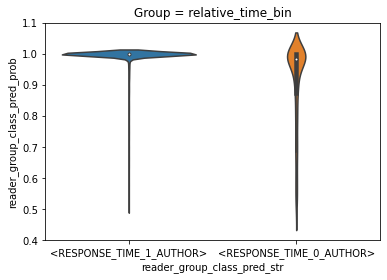

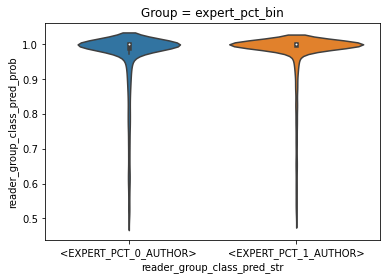

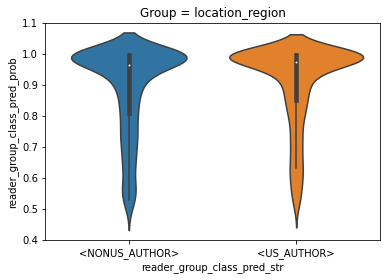

In [20]:
# show distribution of probability
# flatten data
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
for reader_group_i in reader_groups:
    data_i = pred_test_data[pred_test_data.loc[:, 'reader_group']==reader_group_i]
    sns.violinplot(data=data_i, x='reader_group_class_pred_str', y='reader_group_class_pred_prob')
    plt.title(f'Group = {reader_group_i}')
    plt.show()

Based on the skewed distributions, let's take the predictions with $P>=0.99$ and use those to filter the data.

In [23]:
pred_test_data.shape

(31296, 26)

In [24]:
prob_cutoff = 0.99
cutoff_test_data = pred_test_data[pred_test_data.loc[:, 'reader_group_class_pred_prob']>= prob_cutoff]
print(f'{cutoff_test_data.shape[0]}/{pred_test_data.shape[0]} data retained')

25101/31296 data retained


Will this data actually have different generation results, as compared to the full data? We will see!!

In [53]:
## load generated text data
import gzip
text_only_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_token_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rt')))
reader_attention_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/author_attention_layer=5_location=encoder_config=attnconcat/test_data_output_text.gz', 'rt')))
test_data = test_data.assign(**{
    'text_only_model' : text_only_model_output,
    'reader_token_model' : reader_token_model_output,
    'reader_attn_model' : reader_attention_model_output,
})
# add to cutoff data
pred_text_data = pd.concat([cutoff_test_data, test_data.loc[cutoff_test_data.index, ['text_only_model', 'reader_token_model', 'reader_attn_model']]], axis=1)
print(pred_text_data.shape)

(25101, 29)


In [ ]:
## compute overlap metrics etc.
from test_question_generation import STOP_WORDS, test_question_overlap
# suppress BLEU error message
import warnings
warnings.filterwarnings('ignore')
word_embed_file = '../../data/embeddings/wiki-news-300d-1M.vec.gz'
model_output_types = [
    'text_only_model',
    'reader_token_model',
    'reader_attn_model'
]
from nlp.arrow_dataset import Dataset
pred_text_data_torch = Dataset.from_pandas(pred_text_data)
pred_text_data_torch.rename_column_('question', 'target_text')
text_overlap_score_data = []
for model_output_type_i in model_output_types:
    print(f'model={model_output_type_i}')
    overlap_score_data_i = test_question_overlap(
        pred_text_data.loc[:, model_output_type_i].values,
        pred_text_data_torch,
        word_embed_file=word_embed_file,
        stop_words=STOP_WORDS,
    )
    # fix column names
    overlap_score_data_i.rename(columns={
        c : f'{c}_model={model_output_type_i.replace("_model","")}'
        for c in overlap_score_data_i.columns
    }, inplace=True)
    text_overlap_score_data.append(overlap_score_data_i)
text_overlap_score_data = pd.concat(overlap_score_data_i, axis=1)

model=text_only_model


3516it [01:19, 41.84it/s]